In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
from tabulate import tabulate

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [3]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


In [4]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [5]:
def find_the_way(path,file_format):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                files_add.append(os.path.join(r, file))  
    return files_add

In [6]:
ml_list={"DT":DecisionTreeClassifier()}#,"SVC":SVC()}}

In [7]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [8]:
folder("results")

## Calculation of evaluations

In [18]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=np.nan
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [31]:
def ML_CV(loop1,loop2,output_csv,cols,dname,sw):
    fold=5
    repetition=2

    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        cm = pd.DataFrame()
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,index_col=0)#,header=None )
            #df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):


                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

      


                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )
    
                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)

                
                
                
                
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)
                
                
                
                
                
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        #print()
        if True:
            cm=cm//(repetition*cv)
            graph_name=output_csv+ii+"_confusion matrix.pdf"   
            plt.figure(figsize = (10,7))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             




In [32]:
feature=["sepal.length","sepal.width","petal.length","petal.width","variety"]

In [33]:
ii="iris.csv"
output_csv="oldy.csv"
target_names=["0","1","3"]
dname="old"
i=1

    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  old           1    1     0  DT    0.867    0.897   0.889  0.897  0.873  0.802    nan    0.001     0
 1  old           1    2     0  DT    0.933    0.928   0.928  0.928  0.928  0.899    nan    0.001     0
 2  old           1    3     0  DT    0.967    0.97    0.963  0.97   0.965  0.95     nan    0.001     0
 3  old           1    4     0  DT    1        1       1      1      1      1        nan    0         0.001
 4  old           1    5     0  DT    0.933    0.939   0.939  0.939  0.933  0.9      nan    0.001     0
 5  old           1    1     1  DT    0.967    0.963   0.978  0.963  0.969  0.947    nan    0         0
 6  old           1    2     1  DT    0.967    0.976   0.944  0.976  0.957  0.947    nan    0         0
 7  old           1    3     1  DT    0.833    0.86 

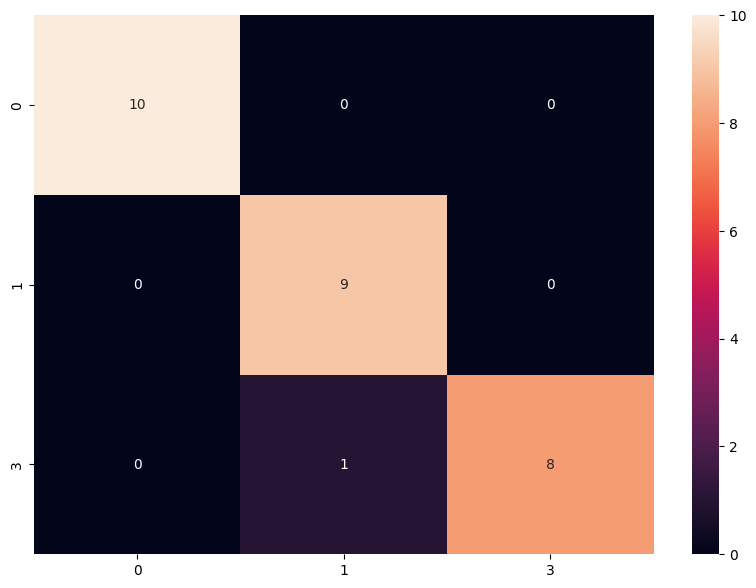

In [34]:
ML_CV(ii,"",output_csv,feature,dname,i)   

In [29]:
def dt_fi(loop1,cols,graph_name="1.pdf"):

    df = pd.read_csv(loop1,usecols=cols)#,index_col=0)#,header=None )
    #df = df.reset_index(drop=True)
    df=df.fillna(0)

    #del df["MAC"] # if dataset has MAC colomn please uncomment this line
    X =df[df.columns[0:-1]]

    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y=df[df.columns[-1]].cat.codes  
    X.shape

    # define the model
    model = DecisionTreeClassifier()
    # fit the model
    model.fit(X, y)
    # get importance
    importance = model.feature_importances_
    # summarize feature importance
    my_xticks=list(X.columns)
    lines={"Feature Name":my_xticks,"Score":importance}
    results = pd.DataFrame (lines)
    print (tabulate(results, headers=list(results.columns)))
    
    plt.bar(my_xticks, importance)
    plt.title("DT feature Importance Scores ")
    #plt.legend(numpoints=1)
    plt.ylabel("FI Score")
    plt.xticks(rotation=90) 
    #plt.ylim([-10, 110]) 
    plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
    plt.show()

    Feature Name        Score
--  --------------  ---------
 0  sepal.length    0.0133333
 1  sepal.width     0.0133333
 2  petal.length    0.550723
 3  petal.width     0.422611


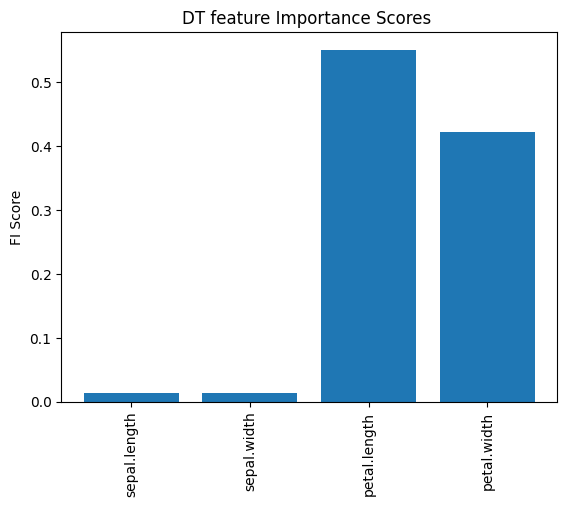

In [30]:
dt_fi(ii,feature)   